<a href="https://colab.research.google.com/github/JulianGlatzer/HplusML/blob/master/MassParameterisedNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Standard imports

In [1]:
region='ge6jge4b'
invertTestTrain=False

In [2]:
#! rm -rf HplusML pandas_INC_{region}.h5
#! wget https://jglatzer.web.cern.ch/jglatzer/hpml/pandas_INC_{region}.h5

In [3]:
#! git clone https://github.com/JulianGlatzer/HplusML
import sys
sys.path.append("HplusML")
#!cd HplusML; git pull origin

In [4]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import HpAlgorithms
import HpMLUtils
import HpKerasUtils
import HpMLPlots
import HpHyperParameterOptimisation
import HpTrainingFrame
import joblib

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.25.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [5]:
df_mc=pd.read_hdf('pandas_INC_'+region+'.h5', 'INC_'+region)
df_mc=df_mc[df_mc.process.apply(lambda x: True if x in ["ttlight","ttb","ttc"] or "Hp" in x else False)]
#print df_mc.process.shape
df_mc['process'].unique()

array(['ttlight', 'ttc', 'ttb', 'Hp200', 'Hp225', 'Hp250', 'Hp275',
       'Hp300', 'Hp350', 'Hp400', 'Hp500', 'Hp600', 'Hp700', 'Hp800',
       'Hp900', 'Hp1000', 'Hp1200', 'Hp1400', 'Hp1600', 'Hp1800',
       'Hp2000'], dtype=object)

# Prepare data for parameterised H+ classification

split into test and training data

In [6]:
hpmasses=[200,225,250,275,300,350,400,500,600,700,800,900,1000,1200,1400,1600,1800,2000]
invertTestTrain=False

verbose=False

datalabel="train2mod0"
if invertTestTrain:
    datalabel="train2mod1"

In [7]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score

def getCallbacks(model):
    """ standard callbacks for Keras """
    return [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(filepath='model_nn_'+str(model.configuration)+"_dropout"+str(model.dropout)+"_l2threshold"+str(model.l2threshold)+".hdf5",
                        monitor='val_loss',
                        save_best_only=True)
      ]

def calculateROCvalues(model, pipe, X_test, y_test, w_test):
    """ calculate ROC values for all H+ masses for a given Keras model and preprocessing pipe """
    roc_values=[]
    
    for hpmass in hpmasses:
        mask=(y_test<=0) | (y_test==hpmass)
        X_ts=X_test[mask].copy()
        y_ts=y_test[mask].copy()
        w_ts=w_test[mask].copy()
        X_ts.hpmass=hpmass
        pipe_steps=pipe.steps
        #transform the pipe and remove the randomizer and augmenter as this would produce lines that we don't want here
        pipe.steps=[step for step in pipe.steps if not isinstance(step[1],HpMTLBackgroundRandomizer) and not isinstance(step[1],HpMTLBackgroundAugmenter)]
        X_ts,y_ts,w_ts=pipe.transform(X_ts, y_ts, sample_weight=w_ts)
        pipe.steps=pipe_steps #reset pipe to original values
        y_ts=(y_ts>0)
        
        roc_value=1.-roc_auc_score(y_ts, model.predict(X_ts.values), sample_weight=w_ts)
        roc_values.append(roc_value)
    return roc_values

In [8]:
def readFromFile(filename="results/BDT_test.txt"):
  """ function to read ROC values for comparison from text files"""
  textfile = open(filename,"r" )
  lst=[]
  for line in textfile:
    lst.append(float(line.strip()))
  return lst

bdttest=readFromFile("results/ROCAUC1m_BDT_test.txt")
nntest=readFromFile("results/ROCAUC1m_NN_test.txt")
bdtmassparamtest=readFromFile("results/ROCAUC1m_massparameterisedBDT_test.txt")
nnmassparamtest=readFromFile("results/ROCAUC1m_massparameterisedNN_test.txt")

plt.style.use('seaborn-white')

def plotabsolute(*inputs, xlow=None, xhigh=None):
  """plots the absolute value of the ROC AUC against the H+ mass, inputs are label, <list of values>, label2, <list of values>,..."""
  plt.figure()
  labels=[]
  arrays=[]
  for i,ipt in enumerate(inputs):
    if i%2:
      arrays.append(ipt)
    else:
      labels.append(ipt)    
      
  color=iter(plt.cm.rainbow(np.linspace(0,1,4+len(arrays))))
  plt.plot(hpmasses, bdttest, color=next(color), label="BDT")
  plt.plot(hpmasses, bdtmassparamtest, color=next(color), label="BDT mass parameterised")
  plt.plot(hpmasses, nntest, color=next(color), label="NN")
  #plt.plot(hpmasses, nnmassparamtest, color=next(color), label="NN mass parameterised")
  for label,array in zip(labels,arrays):
    print("L/R:",label, len(array))
    plt.plot(hpmasses, array, '--', color=next(color), label=label)
  plt.ylabel("1.-ROC AUC")
  plt.xlabel("H+ mass [GeV]")
  if not xlow is None and not xhigh is None:
    plt.xlim((xlow, xhigh))
  plt.ylim((0.,0.5))
  plt.legend()
      
      
def plotrelative(*inputs, xlow=None, xhigh=None):
  """plots the relative value of the ROC AUC (relative to lowest ROC AUC in %) against the H+ mass, inputs are label, <list of values>, label2, <list of values>,..."""
  plt.figure()
  labels=[]
  arrays=[]
  for i,ipt in enumerate(inputs):
    if i%2:
      arrays.append(ipt)
    else:
      labels.append(ipt)  
  
  ratiobdt=[]
  ratiobdtmassparam=[]
  rationn=[]
  rationnmassparam=[]
  ratios=[[] for _ in range(len(arrays))]
  for i in range(len(hpmasses)):
    values=[bdttest[i],bdtmassparamtest[i],nntest[i],nnmassparamtest[i]]
    for arr in arrays:
      values.append(arr[i])
    mn=min(values)
    ratiobdt.append((bdttest[i]-mn)/mn*100)
    ratiobdtmassparam.append((bdtmassparamtest[i]-mn)/mn*100)
    rationn.append((nntest[i]-mn)/mn*100)
    rationnmassparam.append((nnmassparamtest[i]-mn)/mn*100)
    for j,arr in enumerate(arrays):
      ratios[j].append((arr[i]-mn)/mn*100)
      
  color=iter(plt.cm.rainbow(np.linspace(0,1,4+len(arrays))))
  plt.plot(hpmasses, ratiobdt, color=next(color), label="BDT")
  plt.plot(hpmasses, ratiobdtmassparam, color=next(color), label="BDT mass parameterised")
  plt.plot(hpmasses, rationn, color=next(color), label="NN")
  #plt.plot(hpmasses, rationnmassparam, color=next(color), label="NN mass parameterised")
  for label,ratio in zip(labels,ratios):
    print("L/R:",label, len(ratio))
    plt.plot(hpmasses, ratio, '--', color=next(color), label=label)
  plt.ylabel("Difference to lowest [%]")
  plt.xlabel("H+ mass [GeV]")
  if not xlow is None and not xhigh is None:
    plt.xlim((xlow, xhigh))
  plt.ylim((0.,80.))
  plt.legend()

In [9]:
from HpMLUtils import summarizeFitData, FeatureDivider
from HpMLWeightTransformer import MultiSBWeightsScaler
from HpMLMTL import HpMTLBackgroundRandomizer, HpMTLBackgroundAugmenter
from HpMLFeatureNormalisation import WeightedStandardScaler
from HpMLPipeline import PipelineWithWeights
from joblib import dump

def getData(pipe, algo_name, verbose=False):
    """ preprocess H+ data with pipeline <pipe> for training with Keras"""
    htf=HpTrainingFrame.HpTrainingFrame(df_mc)
    X_train, X_test, X_eval, y_train, y_test,y_eval, w_train, w_test, w_eval=htf.prepare(hpmass="multi",addMass=True)
    #summarizeFitData(X_train, y_train, w=w_train,categories=X_train.hpmass)

    if invertTestTrain:
      X_tmp=X_train
      y_tmp=y_train
      w_tmp=w_train
      X_train=X_test
      y_train=y_test
      w_train=w_test
      X_test=X_tmp
      y_test=y_tmp
      w_test=w_tmp

    y_train=X_train.hpmass.copy()
    y_test=X_test.hpmass.copy()

    X_backup=X_test.copy()
    y_backup=y_test.copy()
    w_backup=w_test.copy()

    pipe.fit(X_train,X_train.hpmass, sample_weight=w_train)
    dump(pipe, 'models/'+algo_name+'_pipe_'+region+'_'+datalabel+'.joblib')
    X_train,y_train,w_train=pipe.transform(X_train,y_train, sample_weight=w_train)
    X_test,y_test,w_test=pipe.transform(X_test,y_test, sample_weight=w_test)


    if verbose:
        print("the following is the difference between + and - mass")
        print((w_train*((y_train>0)-0.5)*2).groupby(y_train.abs()).sum())
        print("the following is the sum of weights")
        print(w_train.groupby(y_train).sum())
    
        cats_train=y_train.apply(lambda x: 0 if x<0 else x)
        cats_test =y_test.apply(lambda x: 0 if x<0 else x)
    
        print("Summarizing train data after weighted standard scaler")
        summarizeFitData(X_train, y_train>0, w=w_train,categories=cats_train)
        print("Summarizing test data after weighted standard scaler")
        summarizeFitData(X_test, y_test>0, w=w_test,categories=cats_test)


    y_train=(y_train>0)
    y_test=(y_test>0)
    
    return X_train,y_train, w_train, X_test, y_test, w_test, X_backup, y_backup, w_backup

# Baseline Mass Parameterised NN

Train a mass-parameterised neural network with a randomly assigned H+mass for background events.

In [10]:
msb=MultiSBWeightsScaler(backgroundclass=-1)
rnd=HpMTLBackgroundRandomizer(backgroundclass=-1)
wss=WeightedStandardScaler()
steps=[("msb",msb),("rnd",rnd),("wss",wss)]
pipe=PipelineWithWeights(steps)

X_train,y_train, w_train, X_test, y_test, w_test, X_backup, y_backup, w_backup=getData(pipe,"massparameterisedNN")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
___________________

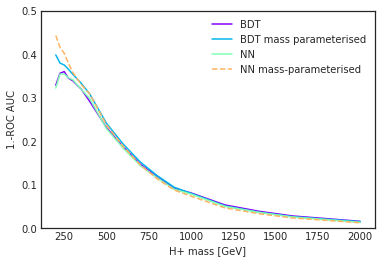

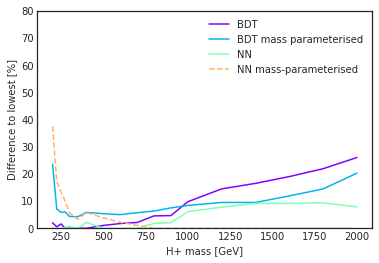

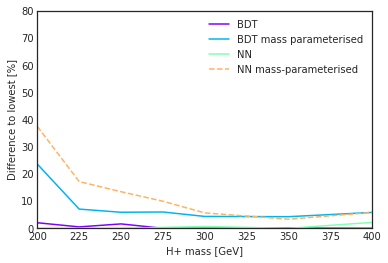

In [11]:
model_baseline=HpKerasUtils.HpFeedForwardModel(configuration=[64,64],dropout=0.1, verbose=True, input_dim=15)
result_baseline=model_baseline.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5,callbacks=getCallbacks(model_baseline))
model_baseline.model.save('models/massparameterisedNNbaseline_'+region+'_'+datalabel+'.h5')
rocvalues_baseline=calculateROCvalues(model_baseline.model,pipe, X_backup, y_backup, w_backup)
plotabsolute("NN mass-parameterised", rocvalues_baseline)
plotrelative("NN mass-parameterised", rocvalues_baseline)
plotrelative("NN mass-parameterised", rocvalues_baseline,xlow=200,xhigh=400)

# Feature Divider

Train a mass-parameterised neural network with a randomly assigned H+ mass for background events and added features that are feature/hpmass.

In [12]:
msb=MultiSBWeightsScaler(backgroundclass=-1)
rnd=HpMTLBackgroundRandomizer(backgroundclass=-1)
fd=FeatureDivider("hpmass")
wss=WeightedStandardScaler()
steps=[("msb",msb),("rnd",rnd),("fd",fd),("wss",wss)]
pipe=PipelineWithWeights(steps)

X_train,y_train, w_train, X_test, y_test, w_test, X_backup, y_backup, w_backup=getData(pipe,"massparameterisedNNfeaturedivider")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                1792      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
_________________________________________________________________
Train on 166812 samples, validate on 166781 samples
Epoch 1/100
166812/166812 [==============================] - 18s 110us/step - loss: 2.40

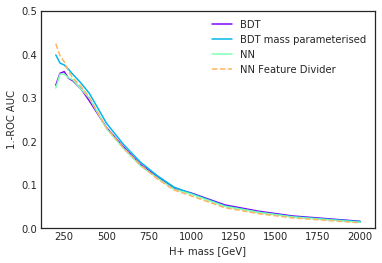

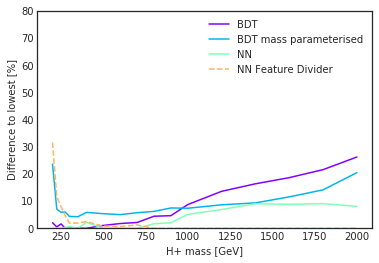

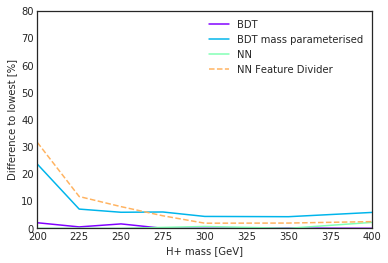

In [13]:
model_featuredivider=HpKerasUtils.HpFeedForwardModel(configuration=[64,64],dropout=0.1, verbose=True, input_dim=27)
result_featuredivider=model_featuredivider.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5,callbacks=getCallbacks(model_featuredivider))
model_featuredivider.model.save('models/massparameterisedNNfeaturedivider_'+region+'_'+datalabel+'.h5')
rocvalues_featuredivider=calculateROCvalues(model_featuredivider.model, pipe, X_backup, y_backup, w_backup)
plotabsolute("NN Feature Divider", rocvalues_featuredivider)
plotrelative("NN Feature Divider", rocvalues_featuredivider)
plotrelative("NN Feature Divider", rocvalues_featuredivider,xlow=200,xhigh=400)

# Data Augmentation

Train a mass-parameterised neural network with a copies of background events for each H+ mass hypothesis (data augmentation).

In [14]:
msb=MultiSBWeightsScaler(backgroundclass=-1)
aug=HpMTLBackgroundAugmenter(backgroundclass=-1)
wss=WeightedStandardScaler()
steps=[("msb",msb),("aug",aug),("wss",wss)]
pipe=PipelineWithWeights(steps)

X_train,y_train, w_train, X_test, y_test, w_test, X_backup, y_backup, w_backup=getData(pipe,"massparameterisedNNdataaugmentation")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                1024      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 5,249
Trainable params: 5,249
Non-trainable params: 0
_________________________________________________________________
Train on 417239 samples, validate on 419622 samples
Epoch 1/100
417239/417239 [==============================] - 47s 114us/step - loss: 1.10

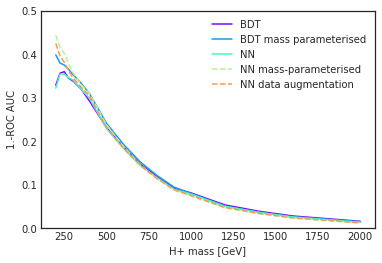

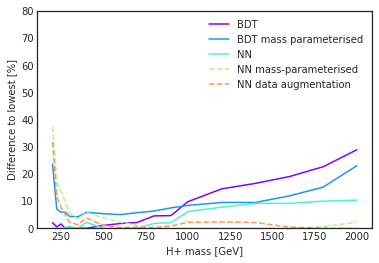

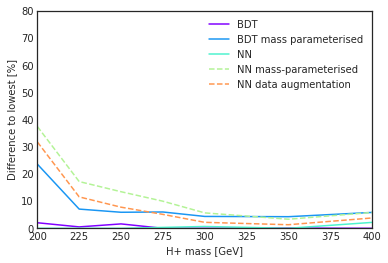

In [15]:
model_dataaugmentation=HpKerasUtils.HpFeedForwardModel(configuration=[64,64],dropout=0.1, verbose=True, input_dim=15)
result_dataaugmentation=model_dataaugmentation.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5,callbacks=getCallbacks(model_dataaugmentation))
model_dataaugmentation.model.save('models/massparameterisedNNdataaugmentation_'+region+'_'+datalabel+'.h5')
rocvalues_dataaugmentation=calculateROCvalues(model_dataaugmentation.model, pipe, X_backup, y_backup, w_backup)
plotabsolute("NN mass-parameterised", rocvalues_baseline, "NN data augmentation", rocvalues_dataaugmentation)
plotrelative("NN mass-parameterised", rocvalues_baseline, "NN data augmentation", rocvalues_dataaugmentation)
plotrelative("NN mass-parameterised", rocvalues_baseline, "NN data augmentation", rocvalues_dataaugmentation,xlow=200,xhigh=400)

# Feature Division and Data Augmentation

Train a mass-parameterised neural network with a copies of background events for each H+ mass hypothesis (data augmentation) and added features that are feature/hpmass.

In [16]:
msb=MultiSBWeightsScaler(backgroundclass=-1)
aug=HpMTLBackgroundAugmenter(backgroundclass=-1)
fd=FeatureDivider("hpmass")
wss=WeightedStandardScaler()
steps=[("msb",msb),("aug",aug),("fd",fd),("wss",wss)]
pipe=PipelineWithWeights(steps)

X_train,y_train, w_train, X_test, y_test, w_test, X_backup, y_backup, w_backup=getData(pipe,"mmassparameterisedNNdataaugmentationandfeaturedivision")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 64)                1792      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
_________________________________________________________________
Train on 417239 samples, validate on 419622 samples
Epoch 1/100
417239/417239 [==============================] - 34s 82us/step - loss: 1.063

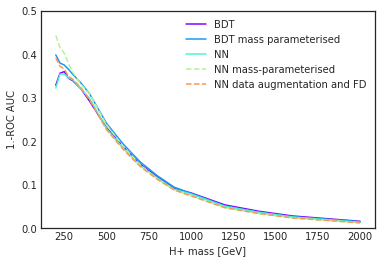

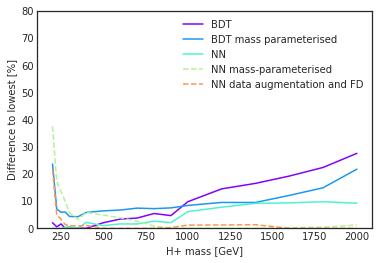

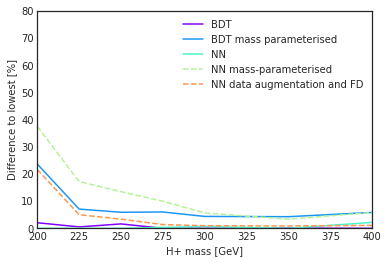

In [17]:
model_dataaugmentationandfeaturedivision=HpKerasUtils.HpFeedForwardModel(configuration=[64,64],dropout=0.1, verbose=True, input_dim=27)
result_dataaugmentationandfeaturedivision=model_dataaugmentationandfeaturedivision.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5,callbacks=getCallbacks(model_dataaugmentationandfeaturedivision))
model_dataaugmentationandfeaturedivision.model.save('models/massparameterisedNNdataaugmentationandfeaturedivision_'+region+'_'+datalabel+'.h5')
rocvalues_dataaugmentationandfeaturedivision=calculateROCvalues(model_dataaugmentationandfeaturedivision.model,pipe, X_backup, y_backup, w_backup)
plotabsolute("NN mass-parameterised", rocvalues_baseline, "NN data augmentation and FD", rocvalues_dataaugmentationandfeaturedivision)
plotrelative("NN mass-parameterised", rocvalues_baseline, "NN data augmentation and FD", rocvalues_dataaugmentationandfeaturedivision)
plotrelative("NN mass-parameterised", rocvalues_baseline, "NN data augmentation and FD", rocvalues_dataaugmentationandfeaturedivision,xlow=200,xhigh=400)

# Checking Other Mass PDFs
making educated guesses about scales for the signal mass points

In [19]:
from HpMLWeightTransformer import WeightsMultiplier
scales={
  200:8.,
  225:8.,
  250:8.,
  275:8.,
  300:16./3.,
  350:4.,
  400:8./3.,
  500:2.,
  600:2.,
  700:2.,
  800:2.,
  900:2.,
  1000:4./3.,
  1200:1.,
  1400:1.,
  1600:1,
  1800:1,
  2000:1.,
}
msb=MultiSBWeightsScaler(backgroundclass=-1)
scl=WeightsMultiplier(scales=scales,backgroundclass=-1)
aug=HpMTLBackgroundAugmenter(backgroundclass=-1)
fd=FeatureDivider("hpmass")
wss=WeightedStandardScaler()
steps=[("msb",msb),("scl",scl),("aug",aug),("fd",fd),("wss",wss)]
pipe=PipelineWithWeights(steps)

X_train,y_train, w_train, X_test, y_test, w_test, X_backup, y_backup, w_backup=getData(pipe,"mmassparameterisedNN1")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 64)                1792      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
_________________________________________________________________
Train on 417239 samples, validate on 419622 samples
Epoch 1/100
417239/417239 [==============================] - 30s 71us/step - loss: 2.601

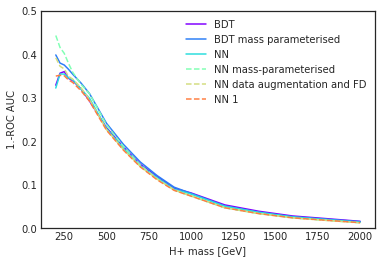

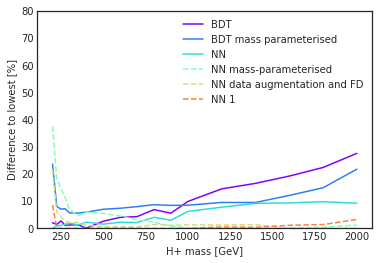

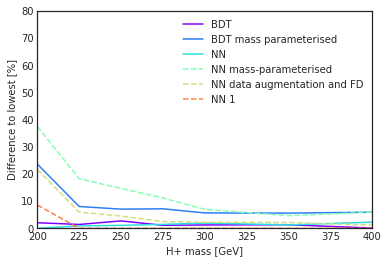

In [20]:
model1=HpKerasUtils.HpFeedForwardModel(configuration=[64,64],dropout=0.1, verbose=True, input_dim=27)
result1=model1.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5,callbacks=getCallbacks(model1))
model1.model.save('models/massparameterisedNN1_'+region+'_'+datalabel+'.h5')
rocvalues1=calculateROCvalues(model1.model,pipe, X_backup, y_backup, w_backup)
plotabsolute("NN mass-parameterised", rocvalues_baseline,"NN data augmentation and FD", rocvalues_dataaugmentationandfeaturedivision, "NN 1", rocvalues1)
plotrelative("NN mass-parameterised", rocvalues_baseline,"NN data augmentation and FD", rocvalues_dataaugmentationandfeaturedivision, "NN 1", rocvalues1)
plotrelative("NN mass-parameterised", rocvalues_baseline,"NN data augmentation and FD", rocvalues_dataaugmentationandfeaturedivision, "NN 1", rocvalues1, xlow=200,xhigh=400)

In [26]:
scales={
  200:8.,
  225:8.,
  250:8.,
  275:8.,
  300:16./3.,
  350:4.,
  400:8./3.,
  500:2.,
  600:2.,
  700:2.,
  800:2.,
  900:2.,
  1000:4./3.,
  1200:1.,
  1400:1.,
  1600:1.2,
  1800:1.5,
  2000:2.,
}
msb=MultiSBWeightsScaler(backgroundclass=-1)
scl=WeightsMultiplier(scales=scales,backgroundclass=-1)
aug=HpMTLBackgroundAugmenter(backgroundclass=-1)
fd=FeatureDivider("hpmass")
wss=WeightedStandardScaler()
steps=[("msb",msb),("scl",scl),("aug",aug),("fd",fd),("wss",wss)]
pipe=PipelineWithWeights(steps)

X_train,y_train, w_train, X_test, y_test, w_test, X_backup, y_backup, w_backup=getData(pipe,"mmassparameterisedNN2")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 64)                1792      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 65        
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
_________________________________________________________________
Train on 417239 samples, validate on 419622 samples
Epoch 1/100
417239/417239 [==============================] - 30s 72us/step - loss: 2.700

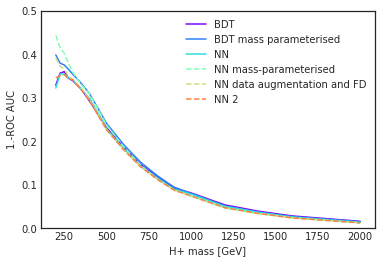

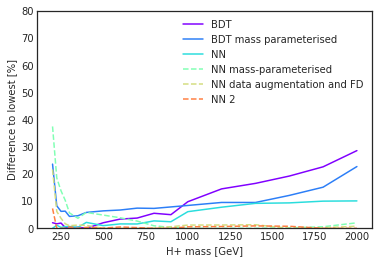

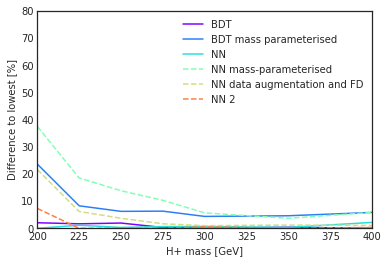

In [27]:
model2=HpKerasUtils.HpFeedForwardModel(configuration=[64,64],dropout=0.1, verbose=True, input_dim=27)
result2=model2.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5,callbacks=getCallbacks(model2))
model2.model.save('models/massparameterisedNN2_'+region+'_'+datalabel+'.h5')
rocvalues2=calculateROCvalues(model2.model, pipe, X_backup, y_backup, w_backup)
plotabsolute("NN mass-parameterised", rocvalues_baseline,"NN data augmentation and FD", rocvalues_dataaugmentationandfeaturedivision, "NN 2", rocvalues2)
plotrelative("NN mass-parameterised", rocvalues_baseline,"NN data augmentation and FD", rocvalues_dataaugmentationandfeaturedivision, "NN 2", rocvalues2)
plotrelative("NN mass-parameterised", rocvalues_baseline,"NN data augmentation and FD", rocvalues_dataaugmentationandfeaturedivision, "NN 2", rocvalues2, xlow=200,xhigh=400)

In [28]:
scales={
  200:16.,
  225:8.,
  250:8.,
  275:8.,
  300:16./3.,
  350:4.,
  400:8./3.,
  500:2.,
  600:2.,
  700:2.,
  800:2.,
  900:2.,
  1000:4./3.,
  1200:1.,
  1400:1.,
  1600:1.2,
  1800:1.5,
  2000:4.,
}
msb=MultiSBWeightsScaler(backgroundclass=-1)
scl=WeightsMultiplier(backgroundclass=-1,scales=scales)
aug=HpMTLBackgroundAugmenter(backgroundclass=-1)
fd=FeatureDivider("hpmass")
wss=WeightedStandardScaler()
steps=[("msb",msb),("scl",scl),("aug",aug),("fd",fd),("wss",wss)]
pipe=PipelineWithWeights(steps)

X_train,y_train, w_train, X_test, y_test, w_test, X_backup, y_backup, w_backup=getData(pipe,"mmassparameterisedNN3")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 64)                1792      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 65        
Total params: 6,017
Trainable params: 6,017
Non-trainable params: 0
_________________________________________________________________
Train on 417239 samples, validate on 419622 samples
Epoch 1/100
417239/417239 [==============================] - 46s 111us/step - loss: 2.99

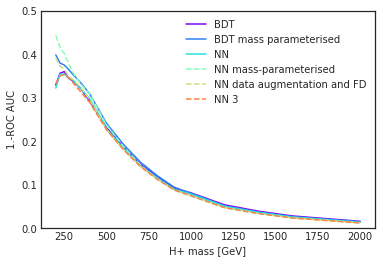

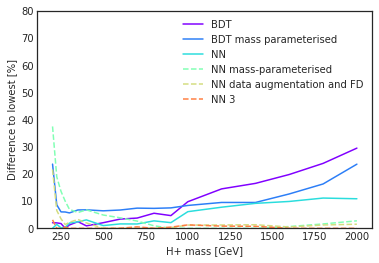

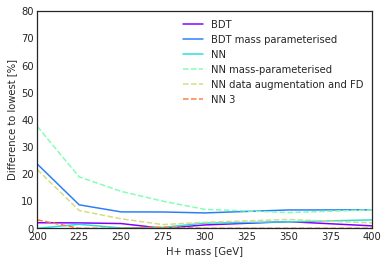

In [29]:
model3=HpKerasUtils.HpFeedForwardModel(configuration=[64,64],dropout=0.1, verbose=True, input_dim=27)
result3=model3.train((X_train.values, y_train.values, w_train.values),(X_test.values, y_test.values, w_test.values), patience=5,callbacks=getCallbacks(model3))
model3.model.save('models/massparameterisedNN3_'+region+'_'+datalabel+'.h5')
rocvalues3=calculateROCvalues(model3.model, pipe,  X_backup, y_backup, w_backup)
plotabsolute("NN mass-parameterised", rocvalues_baseline,"NN data augmentation and FD", rocvalues_dataaugmentationandfeaturedivision, "NN 3", rocvalues3)
plotrelative("NN mass-parameterised", rocvalues_baseline,"NN data augmentation and FD", rocvalues_dataaugmentationandfeaturedivision, "NN 3", rocvalues3)
plotrelative("NN mass-parameterised", rocvalues_baseline,"NN data augmentation and FD", rocvalues_dataaugmentationandfeaturedivision, "NN 3", rocvalues3, xlow=200,xhigh=400)